<a href="https://colab.research.google.com/github/trodrigue1304/Fraud_detection_algorithm/blob/rod/source.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Chargement des données et paramétrage de l'environnement de travail**

In [ ]:
# Chargement des packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import sklearn as skl
import seaborn as sns
from google.colab import drive
from sklearn.impute import KNNImputer

# Connexion à google drive et importation des données
drive.mount('/content/drive')
id_train=pd.read_csv('/content/drive/My Drive/projet python/train_identity.csv')
tr_train=pd.read_csv('/content/drive/My Drive/projet python/train_transaction.csv')
id_test=pd.read_csv('/content/drive/My Drive/projet python/test_identity.csv')
tr_test=pd.read_csv('/content/drive/My Drive/projet python/test_transaction.csv')

## Affichage de toutes les lignes pour les outputs
pd.options.display.max_rows = 4000

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Première exploration des données**

**Visualisation des données**

In [ ]:
id_train.head(10)

In [ ]:
tr_train.head(10)

In [ ]:
#verifier que toutes les TransactionID de id_train existe dans tr_train
print("Taille de la base identity : ",id_train.shape)
print("Taille de la base transaction : ",tr_train.shape)
print("Nombre de transactions uniques de la base transaction : ",id_train['TransactionID'].nunique())
print("Nombre de transactions uniques de la base identity : ",tr_train['TransactionID'].nunique())
print("Proportion de transactions avec id information (train): "+"{:.2%}".format(np.sum(tr_train['TransactionID'].isin(id_train['TransactionID'].unique()))/tr_train['TransactionID'].nunique()))
print("Proportion de transactions avec id information (test): "+"{:.2%}".format(np.sum(tr_test['TransactionID'].isin(id_test['TransactionID'].unique()))/tr_test['TransactionID'].nunique()))

On remarque qu'il y a des transactions sans informations d'identification. On ne tiendra pas compte de ces données.

**Fusion des bases de données**

In [ ]:
train=pd.merge(tr_train,id_train,on="TransactionID",how="right")
test=pd.merge(tr_test,id_test,on="TransactionID",how="right")

**Type des variables**

In [ ]:
train.dtypes

**Détection des valeurs manquantes**

In [ ]:
missing_data=train.isnull().sum().sum()
total_data=np.product(train.shape)
print("Proportion de données manquantes dans la base : "+"{:.2%}".format(missing_data/total_data))

In [ ]:
#Fonction pour la visualition de la répartition des données manquantes
def missing_view(data) :
  null_counts = data.isnull().sum()/len(data)
  plt.figure(figsize=(100,20))
  plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical')
  plt.ylabel('Proportion de données manquantes')
  plt.bar(np.arange(len(null_counts)),null_counts)


In [ ]:
#Visualisation
missing_view(train)

Il faudra donc procéder à un traitement des valeurs manquantes et s'il le faut voir l'impact sur les modèles futurs.

**Analyse de la variable d'intérêt**

In [ ]:
#Tableau des effectifs
tab = pd.DataFrame(train.groupby('isFraud').count()['TransactionID'])
tab

In [ ]:
#Visualisation
tab['TransactionID'] = tab['TransactionID']/tab['TransactionID'].sum()
fig, ax = plt.subplots()

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=np.arange(tab.size),
    height=tab['TransactionID'],
    tick_label=['Non Frauduleux', 'Frauduleux']
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Grab the color of the bars so we can make the
# text the same color.
bar_color = bars[0].get_facecolor()

# Add text annotations to the top of the bars.
# Note, you'll have to adjust this slightly (the 0.3)
# with different data.
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.01,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

fig.tight_layout()

ax.set_title("Distribution de la variable isFraud")

  On soupçonne un surapprentissage des modèles sur les valeurs non frauduleuses. On recalibre les données de manière à avoir une répartition uniforme.

In [ ]:
#Recalibrage
class0=np.where(train['isFraud']==0)[0]
class1=np.where(train['isFraud']==1)[0]
class0_downsample=np.random.choice(class0,size=len(class1),replace=False)
Kept_index=sorted([*class0_downsample,*class1])
train_calibrate=train[train.index.isin(Kept_index)]

In [ ]:
#On s'assure que le tirage a été bien fait
tab = pd.DataFrame(train_calibrate.groupby('isFraud').count()['TransactionID'])
tab['TransactionID'] = tab['TransactionID']/tab['TransactionID'].sum()
fig, ax = plt.subplots()

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=np.arange(tab.size),
    height=tab['TransactionID'],
    tick_label=['Non Frauduleux', 'Frauduleux']
)

**Visualisation des données manquantes dans la base recalibré**

In [ ]:
missing_view(train_calibrate)

On remarque que la distribution est quasiment la même avec celle obtenue avant. 
Conclusion : Les données recalibrées sont à l'image des données initiale sur ce plan. On peut donc se restreindre à la nouvelle base pour la suite des travaux.

### **Analyse et traitement des données manquantes**

**Valeurs manquantes suivant la variable d'intérêt**

In [ ]:
missing_view(train_calibrate[train_calibrate.isFraud == 1])
plt.suptitle("Valeurs manquantes sur les données frauduleuses", fontsize=50)

In [ ]:
missing_view(train_calibrate[train_calibrate.isFraud == 0])
plt.suptitle("Valeurs manquantes sur les données non frauduleuses", fontsize=50)

De manière générale, on remarque que la représentation est pratiquement la même. On peut dès lors faire une courbe de sensibilité pour voir le nombre de variables par seuil.

**Courbe de sensibilité**

In [ ]:
train_column_miss = train_calibrate.isnull().any()
print(f'Nombre de variables avec des données manquantes (apprentissage) : {train_column_miss.sum()} .')

In [ ]:
column_miss = train_calibrate.isnull().sum()/train_calibrate.shape[0]
my_series = pd.Series(np.sort(column_miss.values))
sensibility_graph = my_series.value_counts().reset_index().sort_values(by=['index'])
sensibility_graph[0] = np.cumsum(sensibility_graph[0]/sensibility_graph[0].sum())
plt.plot(sensibility_graph['index'], sensibility_graph[0], '-o')

On peut essayer de voir ce qui se passe à partir de 60 % de données manquantes.

In [ ]:
null_counts = train_calibrate.isnull().sum()/len(train_calibrate)
train_data_miss_60 = train_calibrate.filter(items=null_counts[null_counts>=0.6].reset_index()['index'])
msno.heatmap(train_data_miss_60)

On remarque que pour plusieurs des variables, elles prennent conjointement les valeurs manquantes. Couplé au fait que l'apparition des données manquantes est relativement indépendant du caractère frauduleux de la variable, on peut se restreindre aux variables de moins de 60% de valeurs manquantes. De plus, la courbe de sensibilité nous incite à abaisser ce taux à 20% puisqu'il n'y a pas énormément de variables entre 20 et 40%. Une analyse comparative des résultats pourra être ajoutée suivant le seuil choisi.

**Traitement des valeurs manquantes**

In [ ]:
###On décide de ne retenir que les variables de moins de 20% de données manquantes et de procéder à une imputation par KNN 
train_work = train_calibrate.filter(items=null_counts[null_counts<0.2].reset_index()['index'])
train_work.shape

In [ ]:
from sklearn.impute import KNNImputer
train_imputed = KNNImputer(missing_values=np.nan, n_neighbors=5).fit_transform(train_work.select_dtypes(exclude='object'))

In [ ]:
train_imputed

In [ ]:
train_imputed = pd.DataFrame(train_imputed)
train_imputed.columns = train_work.select_dtypes(exclude='object').columns
train_imputed = pd.merge(train_imputed,train_work[np.append('TransactionID',train_work.select_dtypes('object').columns.values)],on="TransactionID",how="left")
train_imputed


### **Feature Selection**

**Preprocessing of categorical features**

In [ ]:
print(train_imputed['P_emaildomain'].value_counts(dropna=False))

In [ ]:
train_imputed['P_emaildomain'] = train_imputed['P_emaildomain'].str.split('.').str.get(0)
sns.catplot(y='P_emaildomain',kind='count',data=train_imputed)

In [ ]:
#On regroupe les modalités peu significatives dans autres
prop = train_imputed['P_emaildomain'].value_counts()/len(train_imputed)
train_imputed['P_emaildomain'] = np.where(train_imputed['P_emaildomain'].isin(prop[prop<0.01].reset_index()['index']), 'Others', train_imputed['P_emaildomain'])
sns.catplot(y='P_emaildomain',kind='count',data=train_imputed)

In [ ]:
train_imputed['R_emaildomain'] = train_imputed['R_emaildomain'].str.split('.').str.get(0)
prop = train_imputed['R_emaildomain'].value_counts()/len(train_imputed)
train_imputed['R_emaildomain'] = np.where(train_imputed['R_emaildomain'].isin(prop[prop<0.01].reset_index()['index']), 'Others', train_imputed['R_emaildomain'])
sns.catplot(y='R_emaildomain',kind='count',data=train_imputed)

In [ ]:
#Traitement textuel de la variable sur les navigateurs
print(train_imputed['id_31'].value_counts(dropna=False))

In [ ]:
import re

def ngram(sentence, len_gram):
  """
    Fonction for splitting sentences into d-grammes
  """
  sentence = sentence.strip()
  sentence_split = re.split(r'[/,\s]\s*', sentence)
  words = [] 
  if len_gram >= len(sentence.split()) :
    sent_len = 1
  else :
    sent_len = len(sentence.split()) - len_gram +1
  for i in range(sent_len):
      words.append(sentence.split()[i:i+len_gram]) 
  return words

def diff_ngram(sent_a, sent_b, len_gram):
  """
    Fonction to evaluate correspondance between sentences
  """
  a = ngram(sent_a, len_gram)
  b = ngram(sent_b, len_gram) 
  cnt = 0 
  for i in a:
      for j in b:
          if i == j:
              cnt += 1
  return cnt/len(a)


In [ ]:
values = train_imputed['id_31'].value_counts().reset_index()['index']
matrix_comparison = np.zeros((len(values), len(values)))
for i in range(len(values)):
  for j in range(len(values)):
    matrix_comparison[i][j] = diff_ngram(values[i], values[j], 1)
mat = pd.DataFrame(matrix_comparison).set_index(values)
mat.columns = values
plt.figure(figsize=(24,20))
sns.heatmap(mat, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
#Select the max per column
### First we replace on the diagonal the 1 value
i = 0
for var in mat.columns:
  mat[var][i] = 0
  i += 1
mod_list = list()
for var in mat.columns:
  tmp = mat[var][mat[var]>=0.75].reset_index()['index']
  tmp[len(tmp)] = var
  mod_list.append(np.array(tmp))

In [ ]:
def common_words(text1, text2) :
  text1_words = text1.strip().split()
  text2_words = text2.strip().split()
  common = set(text1_words).intersection( set(text2_words) )
  text = ' '.join(common)
  return text

In [ ]:
prev_value = []
new_value = []

for elt in mod_list :
  if len(elt) > 0 :
    common_text = elt[0]
    for i in range(1,len(elt)) :
      common_text = common_words(common_text, elt[i])
    for val in elt :
      prev_value.append(val)
      new_value.append(common_text)


In [ ]:
corr_mat = pd.DataFrame(prev_value,new_value).reset_index()
corr_mat.columns = ["New", "Prev"]
corr_mat = corr_mat.drop_duplicates('Prev')

In [114]:
train_imputed = pd.merge(train_imputed,corr_mat,how = 'left', left_on='id_31', right_on='Prev')
train_imputed['id_31'] = np.where(train_imputed['New'].strip().isnull(),train_imputed['id_31'],train_imputed['New'])
train_imputed = train_imputed.drop(["New","Prev"], axis= 1)

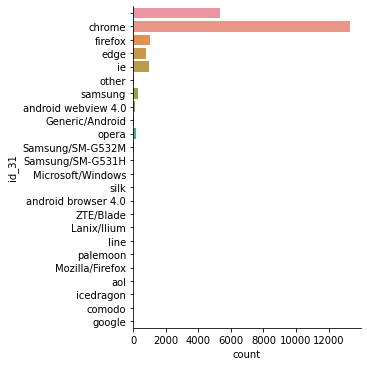

In [115]:
sns.catplot(y='id_31',kind='count',data=train_imputed)

In [116]:
#On voit le nombre de modalités par variable
train_imputed.select_dtypes('object').nunique()

ProductCD         4
card4             4
card6             3
P_emaildomain     8
R_emaildomain     8
id_12             2
id_15             3
id_16             2
id_28             2
id_29             2
id_31            24
id_35             2
id_36             2
id_37             2
id_38             2
DeviceType        2
dtype: int64

In [36]:
#On met les variables categorielles dans un type exploitable
train_imputed_b = train_imputed.copy()
for var in train_imputed_b.select_dtypes('object').columns :
  train_imputed_b[var] = train_imputed_b[var].astype('category')
train_imputed_b = pd.get_dummies(train_imputed_b, columns=train_imputed_b.select_dtypes('object').columns)

### **Logistic Regression (Features Selection and execution)**

In [37]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
import warnings
warnings.filterwarnings('ignore')

**First execution of Logistic Regression**

In [38]:
Y_train=train_imputed_b['isFraud'].astype('int')
X_train=train_imputed_b.drop('isFraud',axis=1)
cv_estimator=LogisticRegression(C=1,random_state=42)

In [40]:
cv_estimator.fit(X_train, Y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
cv_scores = cross_val_score(cv_estimator, X_train, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()

0.7762781344407407

**Recursive Feature Elimination with Cross Validation**

In [43]:
cv_selector = RFECV(cv_estimator,cv= 5, step=1,scoring="F1")
cv_selector = cv_selector.fit(X_train, Y_train)
rfecv_mask = cv_selector.get_support() #list of booleans
rfecv_features = [] 
for bool, feature in zip(rfecv_mask, X_train.columns):
 if bool:
   rfecv_features.append(feature)
print("Optimal number of features :", cv_selector.n_features_)
print("Best features :", rfecv_features)


Optimal number of features : 31
Best features : ['C7', 'C8', 'C11', 'C14', 'V97', 'V99', 'V186', 'V188', 'V189', 'V195', 'V197', 'V199', 'V200', 'V201', 'V229', 'V236', 'V239', 'V246', 'V248', 'V249', 'V257', 'V258', 'V259', 'V260', 'V261', 'ProductCD', 'card6', 'id_28', 'id_29', 'id_35', 'DeviceType']


In [45]:
#Plot best features
n_features = X_train.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features), cv_estimator.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train.columns.values) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

AttributeError: ignored

<Figure size 576x576 with 0 Axes>

**Model with best features from RFECV**

In [47]:
X_train1=X_train.filter(rfecv_features,axis=1)
cv_scores = cross_val_score(cv_estimator, X_train1, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()#verification que le score reste le meme

0.8150080053950504

**Feature importance**

Feature: TransactionID Score: 1.97821
Feature: TransactionDT Score: -1.57346
Feature: TransactionAmt Score: 0.63130
Feature: card1 Score: -0.08632
Feature: card2 Score: -0.16680
Feature: card3 Score: 0.27081
Feature: card5 Score: -0.00089
Feature: C1 Score: -1.88785
Feature: C2 Score: 2.25161
Feature: C3 Score: -0.95461
Feature: C4 Score: 0.65853
Feature: C5 Score: 0.00000
Feature: C6 Score: 0.55959
Feature: C7 Score: -3.03592
Feature: C8 Score: 2.44512
Feature: C9 Score: 0.00000
Feature: C10 Score: 1.90760
Feature: C11 Score: 3.39758
Feature: C12 Score: -0.52551
Feature: C13 Score: -1.75198
Feature: C14 Score: -4.07862
Feature: D1 Score: -0.28672
Feature: V95 Score: 0.04381
Feature: V96 Score: 0.01879
Feature: V97 Score: -0.03697
Feature: V98 Score: -0.04467
Feature: V99 Score: 0.53131
Feature: V100 Score: 0.12384
Feature: V101 Score: 0.08776
Feature: V102 Score: 0.08009
Feature: V103 Score: -0.00828
Feature: V104 Score: -0.34193
Feature: V105 Score: -0.53570
Feature: V106 Score: 0.24

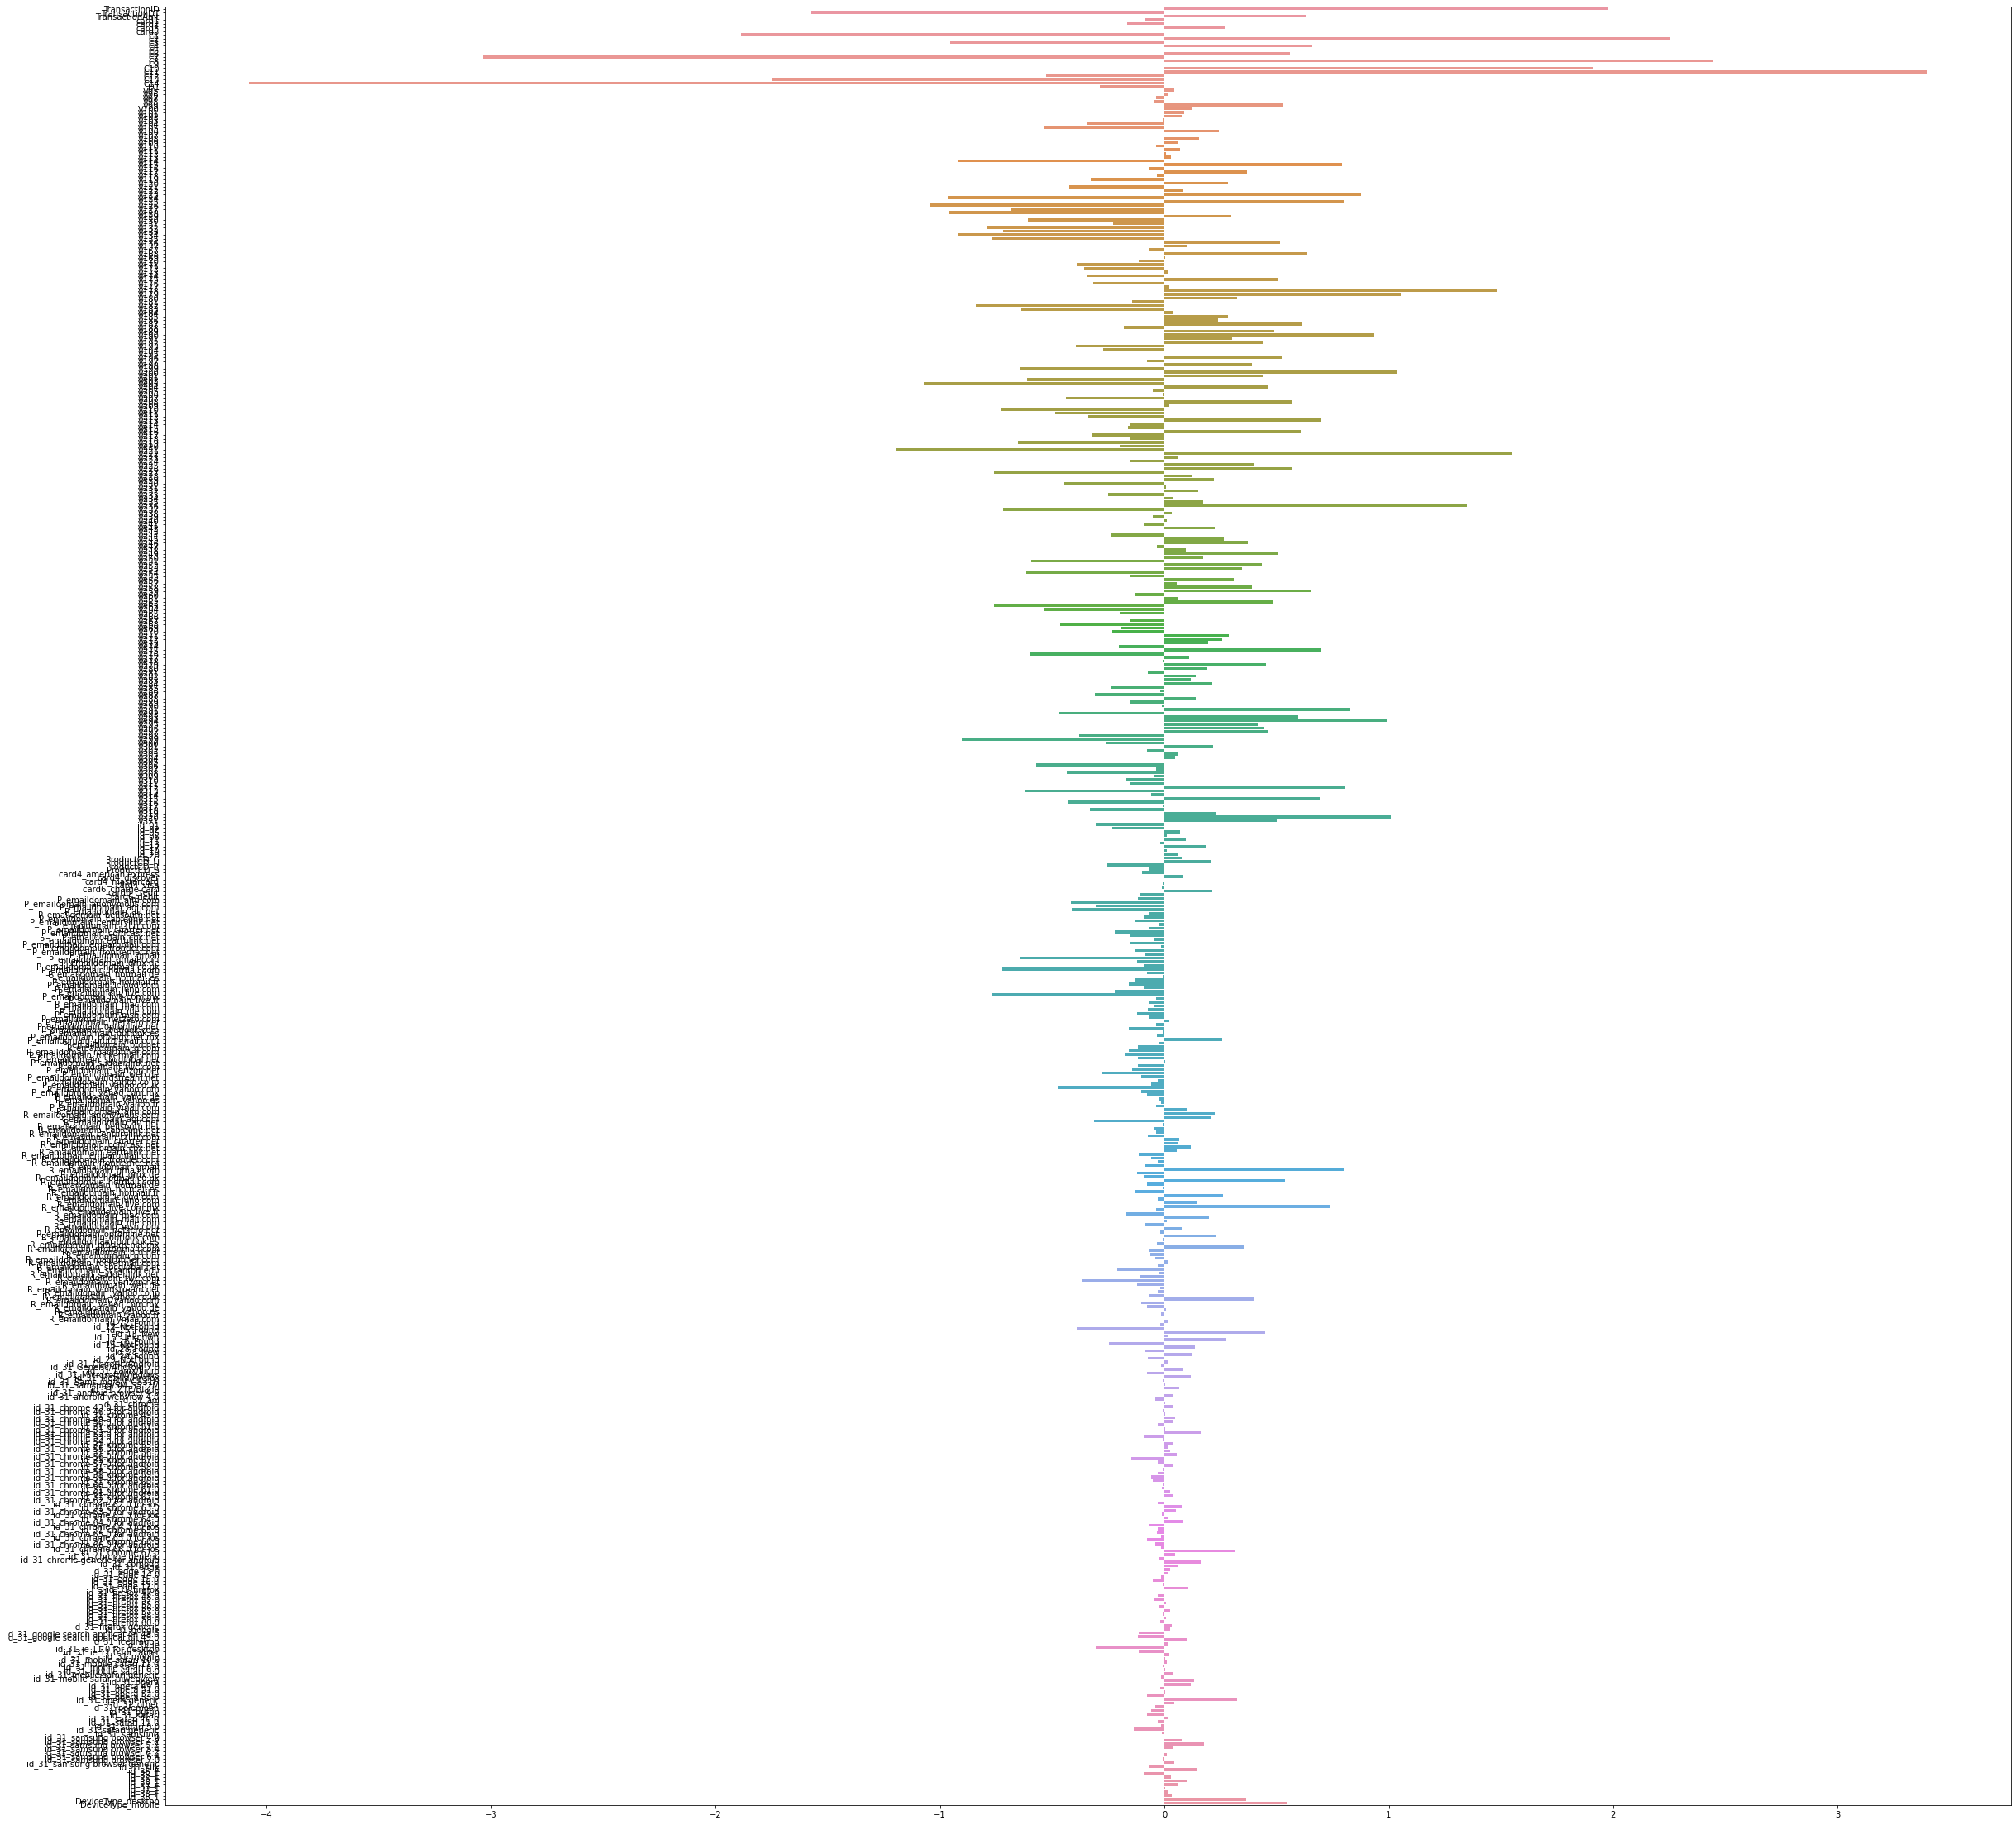

In [ ]:
logit.fit(X_train_st1,Y_train)
importance = logit.coef_[0]
imp=np.zeros(len(importance))
#summarize feature importance
for i,v in enumerate(importance):
	print('Feature:',list(X1_train.columns)[i],'Score: %.5f' % (v))
#plot feature importance
for i,v in enumerate(importance):
  imp[i]='%.5f' % (v)
fig_dims = (40, 40)
fig, ax = plt.subplots(figsize=fig_dims) 
ax = sns.barplot(x=imp, y=list(X1_train.columns),ax=ax)

### **Random Forest (Features Selection and execution)**

In [ ]:
cv_estimator = RandomForestClassifier(random_state =42)
cv_estimator.fit(X_train, Y_train)
cv_selector = RFECV(cv_estimator,cv= 5, step=1,scoring=’accuracy’)
cv_selector = cv_selector.fit(X_train, Y_train)
rfecv_mask = cv_selector.get_support() #list of booleans
rfecv_features = [] 
for bool, feature in zip(rfecv_mask, X_train.columns):
 if bool:
 rfecv_features.append(feature)
print(‘Optimal number of features :’, cv_selector.n_features_)
print(‘Best features :’, rfecv_features)
n_features = X_train.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features), cv_estimator.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train.columns.values) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

**Logistic Regression avec toutes les features(still unclear)**

In [ ]:
sites = ['ProductCD','card4','card6','P_emaildomain','R_emaildomain', 'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_31', 'id_35', 'id_36', 'id_37','id_38','DeviceType']
train1=train_imputed.drop(sites,axis=1)
Y_train=train1['isFraud'].astype('int')
X_train=train1.drop('isFraud',axis=1)
X1_train=pd.merge(X_train,pd.get_dummies(train_imputed[sites]),right_index=True,left_index=True)
scaler=preprocessing.StandardScaler()
X_train_st1=scaler.fit_transform(X1_train)

In [ ]:
logit=LogisticRegression(C=1,random_state=42)
cv_scores = cross_val_score(logit, X_train_st1, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()

0.8367009442032473

**categorical features**

C    12230
R     4528
H     4309
S     1569
Name: ProductCD, dtype: int64


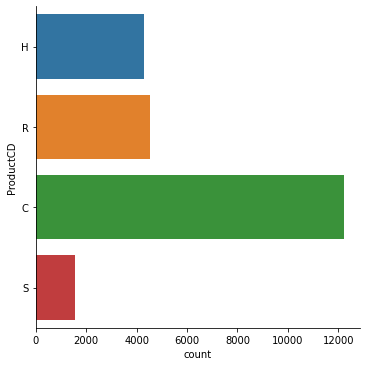

In [ ]:
print(train_imputed['ProductCD'].value_counts(dropna=False))
sns.catplot(y='ProductCD',kind='count',data=train_imputed)
  

visa                13925
mastercard           7387
american express      938
discover              352
NaN                    34
Name: card4, dtype: int64


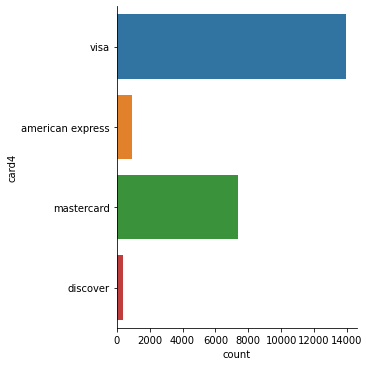

In [ ]:
print(train_imputed['card4'].value_counts(dropna=False))
sns.catplot(y='card4',kind='count',data=train_imputed)

credit         12625
debit           9979
NaN               31
charge card        1
Name: card6, dtype: int64


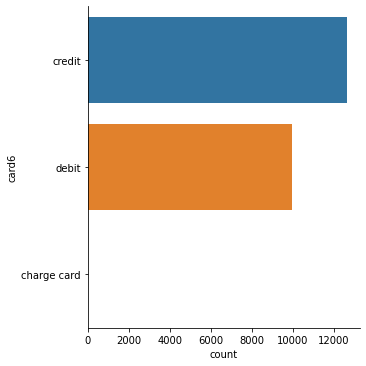

In [ ]:
print(train_imputed['card6'].value_counts(dropna=False))
sns.catplot(y='card6',kind='count',data=train_imputed)

NotFound    19607
Found        3029
Name: id_12, dtype: int64


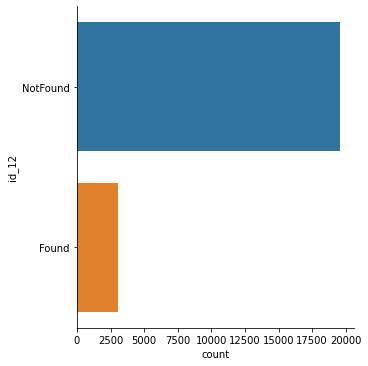

In [ ]:
print(train_imputed['id_12'].value_counts(dropna=False))
sns.catplot(y='id_12',kind='count',data=train_imputed)

Found      12268
New         8071
Unknown     1933
NaN          364
Name: id_15, dtype: int64


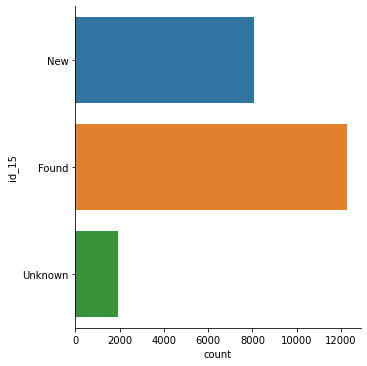

In [ ]:
print(train_imputed['id_15'].value_counts(dropna=False))
sns.catplot(y='id_15',kind='count',data=train_imputed)

Found       12140
NotFound     8199
NaN          2297
Name: id_16, dtype: int64


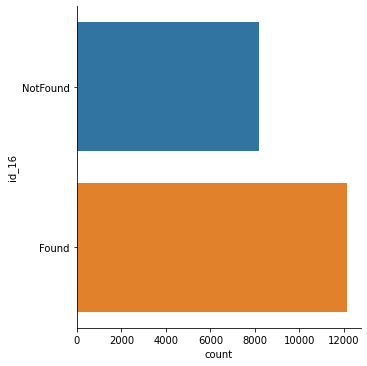

In [ ]:
print(train_imputed['id_16'].value_counts(dropna=False))
sns.catplot(y='id_16',kind='count',data=train_imputed)

Found    13680
New       8588
NaN        368
Name: id_28, dtype: int64


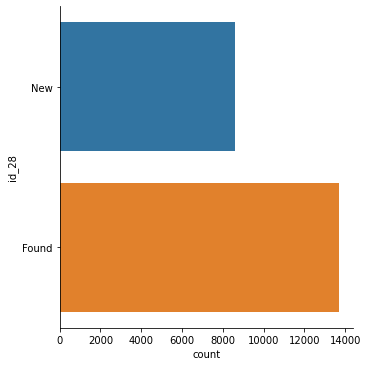

In [ ]:
print(train_imputed['id_28'].value_counts(dropna=False))
sns.catplot(y='id_28',kind='count',data=train_imputed)

Found       13563
NotFound     8705
NaN           368
Name: id_29, dtype: int64


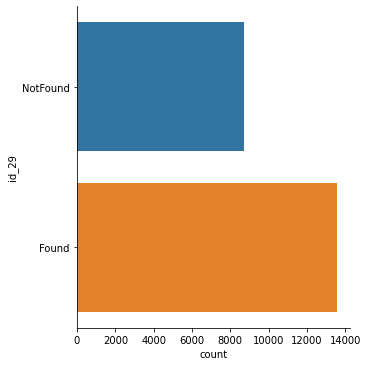

In [ ]:
print(train_imputed['id_29'].value_counts(dropna=False))
sns.catplot(y='id_29',kind='count',data=train_imputed)

F      12382
T       9890
NaN      364
Name: id_35, dtype: int64


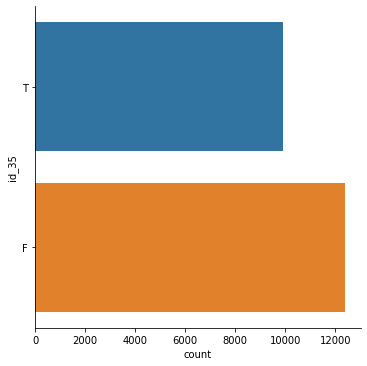

In [ ]:
print(train_imputed['id_35'].value_counts(dropna=False))
sns.catplot(y='id_35',kind='count',data=train_imputed)

F      21486
T        786
NaN      364
Name: id_36, dtype: int64


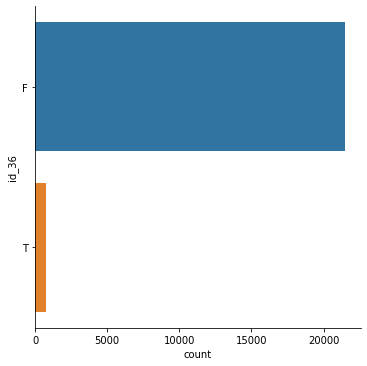

In [ ]:
print(train_imputed['id_36'].value_counts(dropna=False))
sns.catplot(y='id_36',kind='count',data=train_imputed)

T      17846
F       4426
NaN      364
Name: id_37, dtype: int64


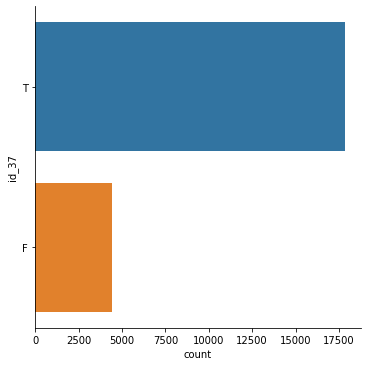

In [ ]:
print(train_imputed['id_37'].value_counts(dropna=False))
sns.catplot(y='id_37',kind='count',data=train_imputed)

F      12911
T       9361
NaN      364
Name: id_38, dtype: int64


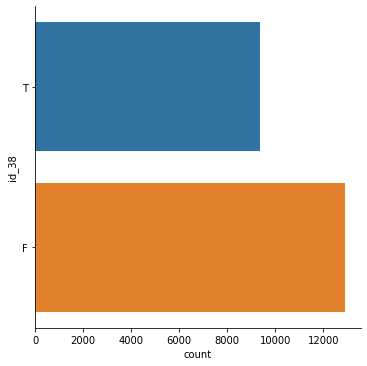

In [ ]:
print(train_imputed['id_38'].value_counts(dropna=False))
sns.catplot(y='id_38',kind='count',data=train_imputed)

desktop    12414
mobile      9833
NaN          389
Name: DeviceType, dtype: int64


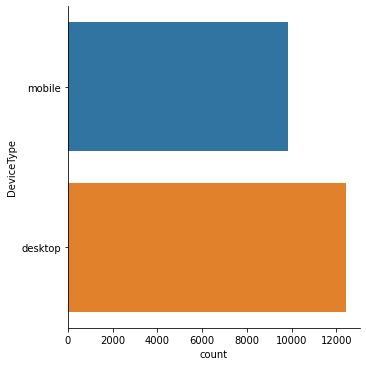

In [ ]:
print(train_imputed['DeviceType'].value_counts(dropna=False))
sns.catplot(y='DeviceType',kind='count',data=train_imputed)